In [1]:
# Sample API
import flowx
import simulation
flowx.__version__

'0.1.dev'

In [2]:
# Define grid parameters
nx, ny = 100, 50
xmin, xmax = -3.0, 7.0
ymin, ymax = -2.5, 2.5

Re   = 100.0
dt   = 1e-3
tmax = 20.

# Define cell-centered variable names
center_vars = ['pres', 'divp', 'divc', 'ibmf']
face_vars   = ['velc', 'hvar', 'forc', 'ibmf']

# Define boundary conditions for variable pressure and velocity [left, right, bottom, top]
bc_type_pres = {'pres': ['neumann', 'neumann', 'neumann', 'neumann']}
bc_val_pres  = {'pres': [0.0, 0.0, 0.0, 0.0]}

bc_type_u = {'velc': ['dirichlet', 'outflow', 'dirichlet', 'dirichlet']}
bc_val_u  = {'velc': [1.0, 0.0, 0.0, 0.0]}

bc_type_v = {'velc': ['dirichlet', 'neumann', 'dirichlet', 'dirichlet']}
bc_val_v  = {'velc': [0.0, 0.0, 0.0, 0.0]}


# Create the grid and data
gridc = flowx.Grid('cell-centered', center_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_pres, user_bc_val=bc_val_pres)

gridx = flowx.Grid('x-face', face_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_u, user_bc_val=bc_val_u)

gridy = flowx.Grid('y-face', face_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_v, user_bc_val=bc_val_v)

scalars = flowx.Scalars(tmax=20.0, dt=1e-3, Re=100.0)

In [3]:
simulation.set_initial_velocity(gridc, gridx, gridy, 'velc', 'pres')

------------ Time = 0.0 ---------------
Number of poisson iterations    : 1
Final poisson residual : 0.0
Max, Min, U   : 1.0, -1.0
Max, Min, V   : 0.0, 0.0
Max, Min, P   : 0.0, 0.0
Max, Min, DIV : 0.0, 0.0




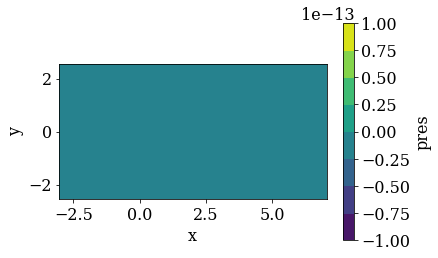

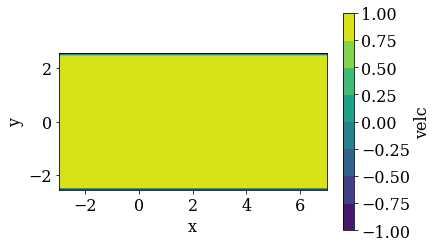

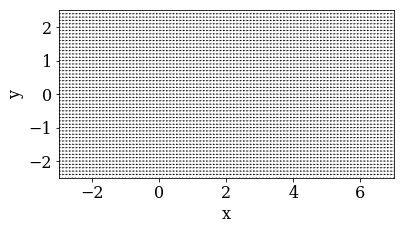

------------ Time = 0.010000000000000002 ---------------
Number of poisson iterations    : 5000
Final poisson residual : 8.605154300357684e-08
Max, Min, U   : 1.0039493059768212, -1.0
Max, Min, V   : 0.00972355804635517, -0.00972355804635524
Max, Min, P   : 0.6981224065049709, -0.6966460153675317
Max, Min, DIV : 4.696153042133e-08, -4.936199348901625e-08


------------ Time = 0.02000000000000001 ---------------
Number of poisson iterations    : 5000
Final poisson residual : 4.2350115618697845e-08
Max, Min, U   : 1.0078360951830654, -1.0
Max, Min, V   : 0.018869478163446758, -0.018869478163446855
Max, Min, P   : 0.6882292380789545, -0.6847021797191825
Max, Min, DIV : 2.2487779594189405e-08, -2.483380063394991e-08


------------ Time = 0.03000000000000002 ---------------
Number of poisson iterations    : 5000
Final poisson residual : 4.1265729603918706e-08
Max, Min, U   : 1.0116354725383034, -1.0
Max, Min, V   : 0.027439146196538824, -0.027439146196538977
Max, Min, P   : 0.67930768462938

KeyboardInterrupt: 

In [4]:
while scalars.time <= scalars.tmax:
    
    # Compute mass in the domain
    Qin = (simulation.get_qin(gridx, 'velc', bc_type_u['velc']) +
           simulation.get_qin(gridy, 'velc', bc_type_v['velc']))
    
    # Update the outflow boundary velocity using a convective equation.
    simulation.update_outflow_bc(gridx, 'velc', scalars.dt)
    
    # Calculate predicted velocity: u* = dt*H(u^n)
    flowx.ins.predictor(gridx, gridy, 'velc', 'hvar', scalars.Re, scalars.dt)

    # Compute mass out of the domain
    Qout = (simulation.get_qout(gridx, 'velc', bc_type_u['velc']) +
            simulation.get_qout(gridy, 'velc', bc_type_v['velc']))
    
    # Rescale velocity at outflow and update BC
    simulation.rescale_velocity(gridx, 'velc', bc_type_u['velc'],
                                Qin, Qout) 
    simulation.update_outflow_bc(gridx, 'velc', scalars.dt, convvel=0.0)
    
    # Calculate RHS for the pressure Poission solver div(u)/dt
    flowx.ins.divergence(gridc, gridx, gridy, 'velc', 'divp', ifac=scalars.dt)
    
    # Solve the pressure Poisson equation 
    ites, res = flowx.poisson.solve_jacobi(gridc, 'pres', 'divp',
                                         maxiter=5000, tol=1e-9)
    scalars.stats['ites'], scalars.stats['res'] = ites, res
    
    # Calculate corrected velocity u^n+1 = u* - dt * grad(P) 
    flowx.ins.corrector(gridc, gridx, gridy, 'velc', 'pres', scalars.dt)
    
    # Calculate divergence of the corrected velocity to display stats
    flowx.ins.divergence(gridc, gridx, gridy, 'velc', 'divc')
    
    # Calculate stats
    scalars.stats.update(flowx.ins.stats(gridc, gridx, gridy, 'velc', 'pres', 'divc'))
    
    # Display stats
    if scalars.nstep % 10 == 0:
        flowx.io.display_stats(scalars.time, scalars.stats)  
        
    if scalars.nstep % 100 == 0:
        flowx.io.plot_contour(gridc, 'pres')
        flowx.io.plot_contour(gridx, 'velc')
        flowx.io.plot_vector(gridx,gridy,'velc')
              
    scalars.advance()

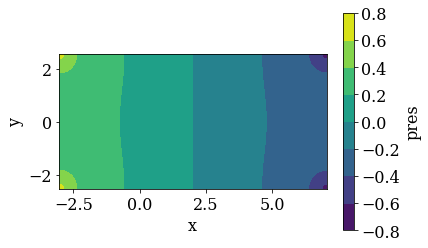

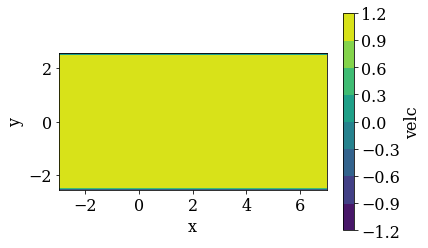

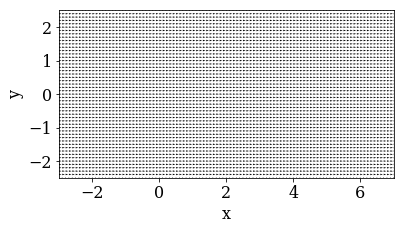

In [5]:
flowx.io.plot_contour(gridc, 'pres')
flowx.io.plot_contour(gridx, 'velc')
flowx.io.plot_vector(gridx,gridy,'velc')